<a href="https://colab.research.google.com/github/maxigaarp/Gestion-De-Datos-en-R/blob/main/Proyecto_solucion_parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto Grupal 

## Entrega: Domingo 29 de Agosto 2021

Porcentaje: 33.3%

Este trabajo consistirá en armar una base de datos en SQL y un informe descriptivo de los datos y la investigación. El objetivo del proyecto es predecir asistencia a clases en base a los datos meteorologicos de precipitación.

La base de datos debe tener la informacion de 3 diferentes fuentes de información:

 * Asistencia Declarada Mensual ([MINEDUC](http://datos.mineduc.cl/dashboards/19844/asistencia-declarada-mensual-por-ano/)) años: (2015-2019)
  Acá se incluyen los porcentajes de asistencia y la cantidad de dias trabajados de todos los alumnos en los distintos colegios de Chile 
 * Reportes de precipitacion Mensual ([CR2](https://www.cr2.cl/camels-cl/)): Datos historicos de precipitacion las distintas estaciones meteorologicas en Chile con localizacion geografica.
 * Localizacion Colegios (Propia/Google Maps):
 Datos de la ubicacion geografica de los colegios en Chile.

Para esto generar esta base de datos se espera que se incluyan a lo menos 3 diferentes tablas:
 * alumnos: Informacion relevante de los alumnos. A lo menos incluir 3 atributos.
 * colegios: Informacion relevante de los colegios. A lo menos incluir 3 atributos, ademas:  nombre (o ID) de la estacion meteorologica más cercana y la distancia a esta, asumiendo latitud y longitud como coordenadas cartesianas.
 * estudia_en: Informacion relevante del vinculo entre el colegio, mes y alumnos. En la tabla se debe incorporar la informacion mensual para cada alumno en terminos de: asistencia, precipitacion. En este caso la precipitacion debe ser una interpolacion en base a los datos de las precipitaciones de las estaciones meteorologicas y la geolocalizacion de los colegios.

Cabe destacar que las bases de datos no se encuentran libres de errores por lo que para consolidar la informacion hay que solucionar problemas de consistencia, completitud, validez. Entre otros se busca que:

 * Que los datos para cada uno atributos se encuentren en el formato adecuado y unico. Para lograr esto revisar los atributos más importantes: asistencia y precipitacion.
 * Una unica forma de expresar valores nulos (unificar distintos tipos de descripcion de valores nulos, ejemplo: " ", NA, 0, -9999, etc). 
 * Seleccionar una cantidad tolerable (mayor que 2 al menos) de valores nulos para las series temporales (los registros de las estaciones meteorologicas). Interpolar los valores nulos en las series.

Cabe destacar que las tablas deben unificarse en SQL cargando las tablas mediante RSQL. Luego de esto se espera que se seleccione y utilice un algoritmo adecuado para generar una predicción de asistencia a clases en base a la precipitacion mensual, puede ser alguno de los siguientes: k-means, regresion lineal, regresion logistica.

La entrega del proyecto debe tener dos partes: 
* El codigo donde se genera la base de datos y el desarrollo del algoritmo de prediccion. Puede ser Colab o script de R, debe tener comentarios solo con el objetivo de guiar al ayudante en la correccion.
* Un documento de no mas de 3 paginas (sin incluir gráficos) con la documentacion de los datos (diagrama ER, tipo de datos, descripcion, dominio, etc. Pueden guiarse por el esquema de registro en las bases de datos del MINEDUC.) y además un resumen de lo desarrollado en el proyecto (como se generaron las variables, como se procesaron y que resultados se obtuvieron)

Para una mejor calidad en el informe usar graficos y tablas que pueden incluir en anexos.



Datos disponibles en: https://drive.google.com/drive/folders/17Or8k6rhYvkaeEn_pD10za8A9jluYfUF?usp=sharing

#Descargar datos

In [ ]:
install.packages("RSQLite")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plogr’




In [ ]:
library(tidyverse)
library(data.table)
library(RSQLite)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




##Asistencia

In [ ]:
system("gdown --id 1-q1ydcu6afA3LQ9uxlh9J9B9kvEJvrRs")

In [ ]:
unzip("/content/DatosProyecto.zip")

In [ ]:
library(stringr)

In [ ]:
lista <- list.files("/content/content/drive/MyDrive/Gestion de Datos/Datos Proyecto/Datos asistencia")
directorio <- "/content/content/drive/MyDrive/Gestion de Datos/Datos Proyecto/Datos asistencia/"

for (name in lista){
  if (str_detect(name, ".rar")){
    foldername<-substr(name, 1, nchar(name)-4)
    system(paste("mkdir 'Asistencia/",foldername,"'",sep=""))
    system(paste("unrar x '",directorio,name,"' 'Asistencia/",substr(name, 1, nchar(name)-4),"/'", sep=""),intern = T)
  }
  else {
    unzip(paste(directorio,name,sep=""), exdir="Asistencia")
  }
}


In [ ]:
lista_de_csvs <- list.files("Asistencia",pattern = ".(CSV|csv)$", recursive = TRUE)


In [ ]:
conn <- dbConnect(RSQLite::SQLite(), "mineduc.db")


In [ ]:
colenames <- c("AGNO","RBD",  "NOM_RBD", "COD_DEPE")
est_ennames <- c("MRUN", "RBD", "AGNO", "MES_ESCOLAR", "COD_ENSE", "COD_GRADO", "DIAS_TRABAJADOS",  "ASIS_PROMEDIO")
alusnames <- c("AGNO", "MRUN", "FEC_NAC_ALU", "GEN_ALU")


for (i in 1:length(lista_de_csvs)) {
  csvs <- lista_de_csvs[i]
  data <- fread(paste("Asistencia/",csvs, sep=""), dec=",")
  if ("NOM_REG_RBD_A" %in% toupper(names(data))){
    data <- select(data, !"NOM_REG_RBD_A")
  }

  names(data) <- toupper(names(data))

  coles <- data %>%
           select(colenames) %>%
           distinct()

  est_en <- data %>%
           select(est_ennames) %>%
           distinct()

  alus <- data %>%
           select(alusnames) %>%
           distinct()

  apnd <- if (i==1) FALSE else TRUE

  dbWriteTable(conn , name = "colegios", 
                  value = coles,
                  row.names = FALSE, header = !apnd ,append=apnd,
                  colClasses='character')

  dbWriteTable(conn , name = "estudia_en", 
                  value = est_en,
                  row.names = FALSE, header = !apnd ,append=apnd,
                  colClasses='character')

  dbWriteTable(conn , name = "alumnos", 
                  value = alus,
                  row.names = FALSE, header = !apnd ,append=apnd,
                  colClasses='character')
}


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(colenames)` instead of `colenames` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(est_ennames)` instead of `est_ennames` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(alusnames)` instead of `alusnames` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



#Nulos

Todos los nulos a un solo formato

In [ ]:
dbExecute(conn,"UPDATE alumnos
SET GEN_ALU = NULL
WHERE GEN_ALU=0")

dbExecute(conn,"UPDATE alumnos
SET FEC_NAC_ALU	 = NULL
WHERE FEC_NAC_ALU=190001 or FEC_NAC_ALU=180001")

[1] 241

[1] 736

Contar nulos

In [ ]:
dbGetQuery(conn, "select 
  sum(case when MRUN is null then 1 else 0 end) MRUN,
  sum(case when AGNO is null then 1 else 0 end) AGNO,
  sum(case when MES_ESCOLAR is null then 1 else 0 end) MES_ESCOLAR,
  sum(case when RBD is null then 1 else 0 end) RBD,
  sum(case when COD_ENSE is null then 1 else 0 end) COD_ENSE,
  sum(case when COD_GRADO is null then 1 else 0 end) COD_GRADO,
  sum(case when DIAS_TRABAJADOS is null then 1 else 0 end) DIAS_TRABAJADOS,
  sum(case when ASIS_PROMEDIO is null then 1 else 0 end) ASIS_PROMEDIO
from estudia_en")

MRUN,AGNO,MES_ESCOLAR,RBD,COD_ENSE,COD_GRADO,DIAS_TRABAJADOS,ASIS_PROMEDIO
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,1,1


Se deja solo el colegio con mas asistencia del alumno. Tambien puede ser aceptable eliminar los alumnos con muchas inscripciones en colegios

In [ ]:
dbGetQuery(conn, "
select 
MRUN, AGNO, MES_ESCOLAR,
COUNT(*) AS COLEGIOS_INSCRITOS
FROM estudia_en
group by MRUN, AGNO, MES_ESCOLAR
ORDER BY COLEGIOS_INSCRITOS DESC
")

MRUN,AGNO,MES_ESCOLAR,COLEGIOS_INSCRITOS
<int>,<int>,<int>,<int>
15606561,2015,12,21
20924355,2015,12,21
15606561,2015,11,20
20924355,2015,11,20
15332159,2015,12,19
19169776,2017,11,19
19169776,2017,12,19
15332159,2015,11,18
8085427,2016,11,16


In [ ]:
dbExecute(conn, "create table ESTUDIAEN as
select 
*
FROM estudia_en
group by MRUN, AGNO, MES_ESCOLAR
having DIAS_TRABAJADOS=max(DIAS_TRABAJADOS)
")

[1] 0

In [ ]:
dbExecute(conn, "
drop table estudia_en
")

[1] 0

## Precipitacion

In [ ]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
unzip("/content/content/drive/MyDrive/Gestion de Datos/Datos Proyecto/cr2_prAmon_2019.zip")

Warning message in unzip("/content/content/drive/MyDrive/Gestion de Datos/Datos Proyecto/cr2_prAmon_2019.zip"):
“error 1 in extracting from zip file”


In [ ]:
pp <- read.csv("/content/cr2_prAmon_2019/cr2_prAmon_2019.txt",na = "-9999", header =F)
pp <- setNames(as.data.frame(t(pp[,-1])),as.character(pp[,1]))


In [ ]:
ppp <- pp %>% select( c("codigo_estacion","nombre", "latitud","longitud") | "2015-01":"2019-12")%>%
        pivot_longer(cols = "2015-01":"2019-12",
        values_to = "Precipitacion",
        names_to = c("Año", "Mes"),
        names_pattern = "(....)-(..)")


In [ ]:
ppp$Precipitacion<-as.numeric(ppp$Precipitacion)
ppp$Año<-as.numeric(ppp$Año)
ppp$Mes<-as.numeric(ppp$Mes)
ppp$longitud<-as.numeric(ppp$longitud)
ppp$latitud<-as.numeric(ppp$latitud)
ppp

codigo_estacion,nombre,latitud,longitud,Año,Mes,Precipitacion
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000005,Visviri,-17.595,-69.4831,2015,1,53.2
1000005,Visviri,-17.595,-69.4831,2015,2,107.0
1000005,Visviri,-17.595,-69.4831,2015,3,118.8
1000005,Visviri,-17.595,-69.4831,2015,4,46.8
1000005,Visviri,-17.595,-69.4831,2015,5,0.0
1000005,Visviri,-17.595,-69.4831,2015,6,0.0
1000005,Visviri,-17.595,-69.4831,2015,7,5.0
1000005,Visviri,-17.595,-69.4831,2015,8,1.4
1000005,Visviri,-17.595,-69.4831,2015,9,5.0


Se toman solo las estaciones con menos de 5 NA en los años elegidos

In [ ]:
ppp <-  ppp %>% group_by(codigo_estacion) %>%
        filter(sum(is.na(Precipitacion))<5) %>%
        ungroup()


Se llenan los NA con los promedios mensuales

In [ ]:
ppp <- ppp %>% group_by(codigo_estacion, Mes)%>%
        mutate(Precipitacion = if_else(is.na(Precipitacion), mean(Precipitacion, na.rm = T), Precipitacion))


In [ ]:
ppp


codigo_estacion,nombre,latitud,longitud,Año,Mes,Precipitacion
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000005,Visviri,-17.595,-69.4831,2015,1,53.2
1000005,Visviri,-17.595,-69.4831,2015,2,107.0
1000005,Visviri,-17.595,-69.4831,2015,3,118.8
1000005,Visviri,-17.595,-69.4831,2015,4,46.8
1000005,Visviri,-17.595,-69.4831,2015,5,0.0
1000005,Visviri,-17.595,-69.4831,2015,6,0.0
1000005,Visviri,-17.595,-69.4831,2015,7,5.0
1000005,Visviri,-17.595,-69.4831,2015,8,1.4
1000005,Visviri,-17.595,-69.4831,2015,9,5.0


In [ ]:
#dbExecute(conn, "drop table precipitacion")
dbWriteTable(conn , name = "precipitacion", 
                  value = ppp,
                  row.names = FALSE, header = TRUE ,
                  colClasses='character')

## Geolocalización




In [ ]:
geocoles <- read.csv("/content/content/drive/MyDrive/Gestion de Datos/Datos Proyecto/colesgeo.csv", row.names=1)

In [ ]:
head(geocoles)

,RBD,NOM_RBD,NOM_COM_RBD,query,lon,lat
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,1,LICEO POLITECNICO ARICA,ARICA,"LICEO POLITECNICO ARICA , ARICA",-70.29469,-18.48719
2,3,ESC. PEDRO VICENTE GUTIERREZ TORRES,ARICA,"ESC. PEDRO VICENTE GUTIERREZ TORRES , ARICA",-70.30278,-18.48696
3,4,LICEO OCTAVIO PALMA PEREZ,ARICA,"LICEO OCTAVIO PALMA PEREZ , ARICA",-70.30792,-18.47417
4,5,JOVINA NARANJO FERNANDEZ,ARICA,"JOVINA NARANJO FERNANDEZ , ARICA",-70.31345,-18.47680
5,7,L. POLI. ANTONIO VARAS DE LA BARRA,ARICA,"L. POLI. ANTONIO VARAS DE LA BARRA , ARICA",-70.28795,-18.47595
6,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,ARICA,"COLEGIO INTEGRADO EDUARDO FREI MONTALVA , ARICA",-70.31737,-18.48267


Filtro territorio chileno

In [ ]:
buenosgeocoles <- geocoles %>% filter((lat>-56.5) &(lat <-17.4) & (lon>-75) & (lon<-67))


In [ ]:
dbWriteTable(conn, name = "geocoles", 
                  value = buenosgeocoles,
                  row.names = FALSE, header = TRUE ,
                  colClasses='character')

#Colegios

Se elige la ultima info que se tiene del colegio (no necesario realmente)

In [ ]:
dbExecute(conn,"
create table colegios2 as 
select * 
from colegios
group by RBD
having AGNO=MAX(AGNO)
")

[1] 0

In [ ]:
dbExecute(conn,"drop table colegios")

[1] 0

# Mezcla

Se crea la tabla combinada 

In [ ]:
dbListTables(conn)

[1] "ESTUDIAEN"     "alumnos"       "colegios2"     "geocoles"     
[5] "precipitacion"

In [ ]:
dbGetQuery(conn,"
select distinct
PP.codigo_estacion,
PP.latitud,
PP.longitud
from Precipitacion as PP")

codigo_estacion,latitud,longitud
<chr>,<dbl>,<dbl>
1000005,-17.5950,-69.4831
1200002,-17.7719,-69.7244
1200003,-17.8350,-69.7039
1201005,-17.8428,-69.6994
1201010,-17.9931,-69.6594
1201003,-18.0036,-69.6331
1202012,-18.1950,-69.5589
1020017,-18.2042,-69.2683
1020016,-18.2164,-69.2956


Se vincula la latitud y longitud de los colegios y las estaciones

In [ ]:
#dbExecute(conn, "drop table colegios_full")
dbExecute(conn,"
create table colegios_full as 
select 
CI.*,
GC.lat as Latitud,
GC.lon as Longitud,
PP.codigo_estacion,
PP.latitud as Lat_Estacion,
PP.longitud as Lon_Estacion,
POWER(PP.longitud - GC.lon, 2)+ POWER(PP.latitud-GC.lat,2) as dist
from colegios2 as CI, geocoles as GC, (
select distinct
PP.codigo_estacion,
PP.latitud,
PP.longitud
from Precipitacion as PP) as PP
where CI.RBD=GC.RBD
group by CI.RBD
having dist=min(dist)
")

[1] 0

In [ ]:
dbGetQuery(conn, "select * from colegios_full")

AGNO,RBD,NOM_RBD,COD_DEPE,Latitud,Longitud,codigo_estacion,Lat_Estacion,Lon_Estacion,dist
<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2019,1,LICEO POLITECNICO ARICA,2,-18.48719,-70.29469,1310018,-18.4775,-70.3208,7.754443e-04
2019,3,ESC. PEDRO VICENTE GUTIERREZ TORRES,2,-18.48696,-70.30278,1310018,-18.4775,-70.3208,4.143417e-04
2019,4,LICEO OCTAVIO PALMA PEREZ,2,-18.47417,-70.30792,1310018,-18.4775,-70.3208,1.769885e-04
2019,5,JOVINA NARANJO FERNANDEZ,2,-18.47680,-70.31345,1310018,-18.4775,-70.3208,5.447059e-05
2019,7,L. POLI. ANTONIO VARAS DE LA BARRA,2,-18.47595,-70.28795,1310018,-18.4775,-70.3208,1.081556e-03
2019,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,2,-18.48267,-70.31737,1310018,-18.4775,-70.3208,3.852273e-05
2019,9,ESCUELA REPUBLICA DE ISRAEL,2,-18.48696,-70.30278,1310018,-18.4775,-70.3208,4.143417e-04
2019,10,ESCUELA REPUBLICA DE FRANCIA,2,-18.47422,-70.30892,1310018,-18.4775,-70.3208,1.518580e-04
2019,11,ESC. GRAL. PEDRO LAGOS MARCHANT,2,-18.49111,-70.31159,1310018,-18.4775,-70.3208,2.700022e-04


In [ ]:
dbGetQuery(conn,"select * from ESTUDIAEN limit 10")


MRUN,RBD,AGNO,MES_ESCOLAR,COD_ENSE,COD_GRADO,DIAS_TRABAJADOS,ASIS_PROMEDIO
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
17,8505,2015,3,610,2,20,0.7500
17,8505,2015,4,610,2,21,0.6667
17,8505,2015,5,610,2,17,0.5294
17,8505,2015,6,610,2,16,0.7500
17,8505,2015,7,610,2,11,0.9091
17,8505,2015,8,610,2,21,0.8095
17,8505,2015,9,610,2,20,0.7000
17,8505,2015,10,610,2,21,0.5238
17,8505,2015,11,610,2,21,0.8095


In [ ]:
dbGetQuery(conn,"select * from Precipitacion limit 10")


codigo_estacion,nombre,latitud,longitud,Año,Mes,Precipitacion
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000005,Visviri,-17.595,-69.4831,2015,1,53.2
1000005,Visviri,-17.595,-69.4831,2015,2,107.0
1000005,Visviri,-17.595,-69.4831,2015,3,118.8
1000005,Visviri,-17.595,-69.4831,2015,4,46.8
1000005,Visviri,-17.595,-69.4831,2015,5,0.0
1000005,Visviri,-17.595,-69.4831,2015,6,0.0
1000005,Visviri,-17.595,-69.4831,2015,7,5.0
1000005,Visviri,-17.595,-69.4831,2015,8,1.4
1000005,Visviri,-17.595,-69.4831,2015,9,5.0


In [ ]:
q<-dbSendQuery(conn, "
select
ESTUDIAEN.ASIS_PROMEDIO,
colegios_full.latitud,
Precipitacion.Precipitacion
from ESTUDIAEN, colegios_full, Precipitacion
where ESTUDIAEN.RBD=colegios_full.RBD and
colegios_full.codigo_estacion=Precipitacion.codigo_estacion and
ESTUDIAEN.AGNO=Precipitacion.Año and
ESTUDIAEN.MES_ESCOLAR=Precipitacion.Mes
")

# Regresion

dbSendQuery: 

In [ ]:
conection<-dbSendQuery(conn, "
                          select
                          ESTUDIAEN.ASIS_PROMEDIO,
                          colegios_full.latitud,
                          Precipitacion.Precipitacion
                          from ESTUDIAEN, colegios_full, Precipitacion
                          where ESTUDIAEN.RBD=colegios_full.RBD and
                          colegios_full.codigo_estacion=Precipitacion.codigo_estacion and
                          ESTUDIAEN.AGNO=Precipitacion.Año and
                          ESTUDIAEN.MES_ESCOLAR=Precipitacion.Mes
                          limit 12000
                          ")

Warning message:
“Closing open result set, pending rows”


ASIS_PROMEDIO=0.7521-0.002685*Latitud-0.0001125*Precipitacion

In [ ]:
m1<-glm(ASIS_PROMEDIO~Latitud+Precipitacion, data=dbFetch(conection, 6000))
summary(m1)


Call:
glm(formula = ASIS_PROMEDIO ~ Latitud + Precipitacion, data = dbFetch(conection, 
    6000))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.89219  -0.02048   0.10816   0.15818   0.20659  

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.521e-01  2.135e-02  35.230  < 2e-16 ***
Latitud       -2.685e-03  6.304e-04  -4.259 2.08e-05 ***
Precipitacion -1.125e-04  4.734e-05  -2.377   0.0175 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.07488802)

    Null deviance: 450.52  on 5999  degrees of freedom
Residual deviance: 449.10  on 5997  degrees of freedom
AIC: 1481.7

Number of Fisher Scoring iterations: 2


In [ ]:
coefficients(m1)

(Intercept)       Latitud Precipitacion 
 0.7521474445 -0.0026849993 -0.0001125419

In [ ]:
install.packages("speedglm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(speedglm)

In [ ]:
 make.data<-function(chunksize){       
     conection<-NULL
     function(reset=FALSE){
     if(reset){
       conn <- dbConnect(RSQLite::SQLite(), "mineduc.db")
       conection<<-dbSendQuery(conn, "
                                  select
                                  ESTUDIAEN.ASIS_PROMEDIO,
                                  colegios_full.latitud,
                                  Precipitacion.Precipitacion
                                  from ESTUDIAEN, colegios_full, Precipitacion
                                  where ESTUDIAEN.RBD=colegios_full.RBD and
                                  colegios_full.codigo_estacion=Precipitacion.codigo_estacion and
                                  ESTUDIAEN.AGNO=Precipitacion.Año and
                                  ESTUDIAEN.MES_ESCOLAR=Precipitacion.Mes
                                  ")
     } else{
       rval<-dbFetch(conection,chunksize)
       if ((nrow(rval)==0)) {
            conection<<-NULL
            rval<-NULL
       }
       return(rval)
     }
  }
}

In [ ]:
da<-make.data(chunksize=50)

da(reset=T) #1: opens the connection to "data1.txt"
da(reset=F) #2: reads the first 50 rows (out of 120) of the dataset
da(reset=F) #3: reads the second 50 rows (out of 120) of the dataset
da(reset=F) #3: reads the last 20 rows (out of 120) of the dataset
da(reset=F) #4: is NULL: this latter command closes the connection




ASIS_PROMEDIO,Latitud,Precipitacion
<dbl>,<dbl>,<dbl>
0.7500,-33.44102,7.4
0.6667,-33.44102,0.0
0.5294,-33.44102,2.0
0.7500,-33.44102,0.0
0.9091,-33.44102,38.3
0.8095,-33.44102,111.4
0.7000,-33.44102,23.7
0.5238,-33.44102,27.7
0.8095,-33.44102,4.5


ASIS_PROMEDIO,Latitud,Precipitacion
<dbl>,<dbl>,<dbl>
1.0000,-18.49699,0
1.0000,-18.49699,0
1.0000,-18.49699,0
0.9500,-18.49699,0
1.0000,-18.49699,0
1.0000,-18.49699,0
1.0000,-18.49699,0
0.9500,-18.49699,0
1.0000,-18.49699,0


ASIS_PROMEDIO,Latitud,Precipitacion
<dbl>,<dbl>,<dbl>
0.9474000,-18.4462,0
1.0000000,-18.4462,0
0.8636000,-18.4462,0
0.6842000,-18.4462,0
1.0000000,-18.4462,0
0.7619000,-18.4462,0
0.6842000,-18.4462,0
0.8889000,-18.4462,0
0.8571000,-18.4462,0


NULL

In [ ]:
da<-make.data(chunksize=10000000)

b1<-shglm(ASIS_PROMEDIO~Latitud+Precipitacion,datafun=da)
summary(b1) 


Generalized Linear Model of class 'speedglm':

Call:  shglm(formula = ASIS_PROMEDIO ~ Latitud + Precipitacion, datafun = da) 

Coefficients:
 ------------------------------------------------------------------ 
                Estimate Std. Error t value  Pr(>|t|)    
(Intercept)    8.033e-01  1.244e-04  6456.7  0.00e+00 ***
Latitud       -1.101e-03  3.623e-06  -303.8  0.00e+00 ***
Precipitacion  1.958e-06  6.750e-08    29.0 5.83e-185 ***

------------------------------------------------------------------- 
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

---
null df: 151925055; null deviance: 10842672;
residuals df: 151925053; residuals deviance: 10835912;
# obs.: 151925056; # non-zero weighted obs.: 151925056;
AIC: 446513069; log Likelihood: -223256530;
RSS: 10835912; dispersion: 0.07132406; iterations: 3;
rank: 3; max tolerance: 0e+00; convergence: TRUE.

In [ ]:
da<-make.data(chunksize=50000)
da(reset=T)
d<- da(reset=F)

In [ ]:
d <- d%>% filter((ASIS_PROMEDIO>=0) &(ASIS_PROMEDIO<=1))

In [ ]:
d <- d%>% filter(Precipitacion>=0)

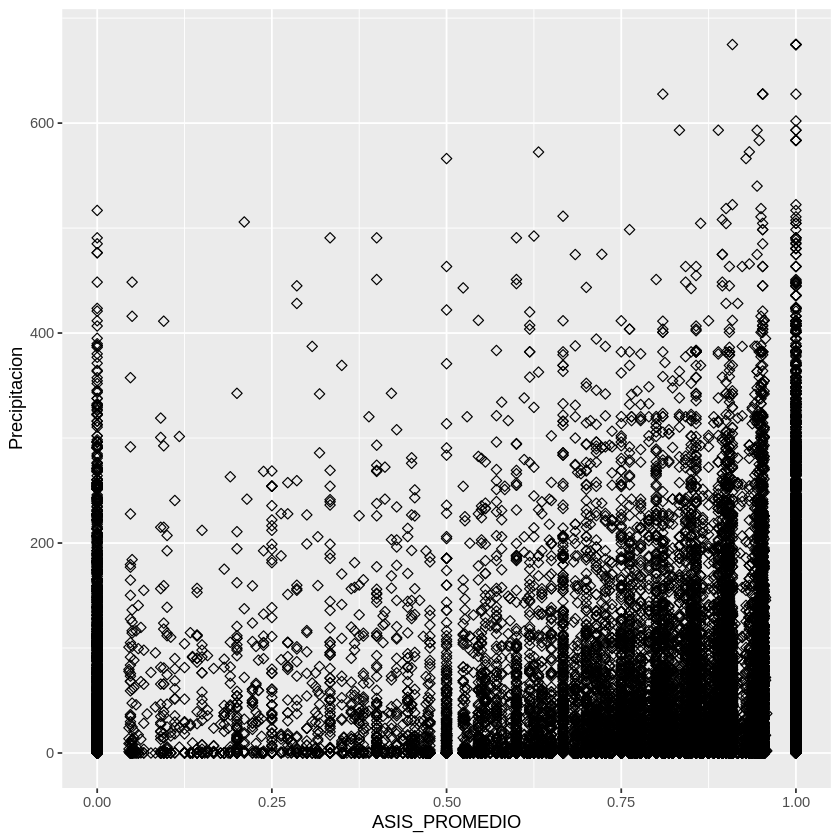

In [ ]:
library(ggplot2)
ggplot(d, aes(x=ASIS_PROMEDIO, y=Precipitacion)) +  geom_point(size=2, shape=23)